# EDA with kaggle dataset and sentinel hub
In this notebook, I try to load satellite images using the sentinel-hub API, for wildfire locations extracted from the kaggle database.
To run this with Landsat data, you need to modify the instance id and the download endpoint in your config.json file. For info on how to do this see here https://sentinelhub-py.readthedocs.io/en/latest/.
You also need to create a "TRUE-COLOR-LANDSAT" (or whatever you want to call it) layer in here https://apps.sentinel-hub.com/dashboard/#/. 

In [124]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, DataSource

In [125]:
def get_bbox(lat_c, lon_c, r=1000):
    """Return lat and lon of lower left 
       and upper right corners of bbox from center and radius. 
       
       
    Parameters
    ----------
    
    lat_c: latitude of center point in decimal degrees.
    lon_c: longitude of center point in decimal degrees.
    r: Length of edge of square box in meters. Default 100.
    
    Returns
    -------
    Y-dY: latitude of upper left corner of bounding box
    X-dX: longitude of upper left corner of bounding box
    Y+dY: latitude of lower right corner of bounding box
    X+dX: longitude of lower right corner of bounding box

    """
    
    
    X=lon_c
    Y=lat_c
    # earth radius
    R = 3.671e6
    dY = 360 * r / R
    dX = dY * np.cos (np.radians (Y)) 
    return [X-dX, Y-dY, X+dX, Y+dY]

In [126]:
# from sentinel hub notebook
def plot_image(image, factor=1):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)

In [127]:
# Get database
cnx = sqlite3.connect("FPA_FOD_20170508.sqlite")

In [128]:
# Extract relevant info
df = pd.read_sql_query("SELECT FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE, DISCOVERY_TIME, \
CONT_DATE, CONT_TIME, FIRE_SIZE FROM 'Fires'", cnx)

In [129]:
# Create usable dates
df['START_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['END_DATE'] = pd.to_datetime(df['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')

In [130]:
df.head()

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,DISCOVERY_TIME,CONT_DATE,CONT_TIME,FIRE_SIZE,START_DATE,END_DATE
0,2005,Miscellaneous,40.036944,-121.005833,CA,2453403.5,1300,2453403.5,1730,0.10,2005-02-02,2005-02-02
1,2004,Lightning,38.933056,-120.404444,CA,2453137.5,0845,2453137.5,1530,0.25,2004-05-12,2004-05-12
2,2004,Debris Burning,38.984167,-120.735556,CA,2453156.5,1921,2453156.5,2024,0.10,2004-05-31,2004-05-31
3,2004,Lightning,38.559167,-119.913333,CA,2453184.5,1600,2453189.5,1400,0.10,2004-06-28,2004-07-03
4,2004,Lightning,38.559167,-119.933056,CA,2453184.5,1600,2453189.5,1200,0.10,2004-06-28,2004-07-03


In [131]:
# Get instances where Landsat 8 is operating
df_recent = df[df["START_DATE"]>"2014-01-01"].copy().reset_index()
df_recent.head()

,index,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,DISCOVERY_TIME,CONT_DATE,CONT_TIME,FIRE_SIZE,START_DATE,END_DATE
0,1721940,2014,Lightning,45.340833,-116.466667,ID,2456852.5,0801,2456852.5,1830,0.1,2014-07-14,2014-07-14
1,1721941,2014,Lightning,45.505278,-116.425556,ID,2456883.5,1220,2456883.5,1600,0.1,2014-08-14,2014-08-14
2,1721942,2014,Lightning,45.908056,-115.767778,ID,2456892.5,1820,2456893.5,1245,0.1,2014-08-23,2014-08-24
3,1721943,2014,Lightning,45.840000,-115.966389,ID,2456884.5,0800,2456884.5,1718,0.1,2014-08-15,2014-08-15
4,1721944,2014,Lightning,45.598333,-115.449167,ID,2456861.5,1015,2456861.5,1700,0.1,2014-07-23,2014-07-23


In [132]:
sample = 0

lat_c = df_recent["LATITUDE"][sample]
lon_c = df_recent["LONGITUDE"][sample]
date = df_recent["START_DATE"][sample]
r = 1000.

box = get_bbox(lat_c, lon_c, r)

In [133]:
# Create bounding box
custom_bbox = BBox(bbox=box, crs=CRS.WGS84)

In [134]:
# Request images for that box, and time window before/after
days_before = 0
days_after = 50
max_cloud_over = 0.1


# Possible to create landsat layer in sentinel-hub
### NOTE: SWITCH DOWNLOAD ENDPOINT IN CONFIG.JSON FOR LANDSAT DATA/S2 DATA
wms_true_color_request = WmsRequest(layer='TRUE-COLOR-LANDSAT',
                                    bbox=custom_bbox,
                                    time=(date - timedelta(days = days_before), date + timedelta(days = days_after)),
                                    width=512, height=856, maxcc=max_cloud_over, \
                                    data_source=DataSource.LANDSAT8)

In [135]:
# Get data
wms_true_color_img = wms_true_color_request.get_data()

In [136]:
# Do we get any images?
print('Returned data is of type = %s and length %d.' % (type(wms_true_color_img), len(wms_true_color_img)))

Returned data is of type = <class 'list'> and length 6.


In [137]:
print('Single element in the list is of type {} and has shape {}'.format(type(wms_true_color_img[-1]),
                                                                         wms_true_color_img[-1].shape))

Single element in the list is of type <class 'numpy.ndarray'> and has shape (856, 512, 3)


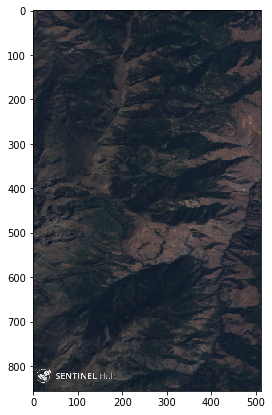

In [138]:
# Plot first image (if 0 images throws error)

plot_image(wms_true_color_img[-1])